A notebook mofdified from the work of Bjorn in the new enviroment, with code updates...in progress March 2022

# Prepare EEG data for training of machine-learning models

In this notebook, the preprocessing for machine learning purposes is done. Also, some exploration and visualization is done to better understand the data at hand.

+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.
+ Extract features
+ Select features

## Import packages & links

In [1]:
# Import packages
import os
import sys

sys.path.insert(0, os.path.dirname(os.getcwd()))

import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

sns.set_theme(style="whitegrid")
%matplotlib inline
# %matplotlib qt

In [3]:
from config_for_repro_prepro import PATH_RAW_DATA, PATH_METADATA, PATH_DATA_PROCESSED_ML
import re
from itertools import islice

In [4]:
PATH_DATA_PROCESSED_ML

'C:/Projects\\EEG_explorer\\Data/data_processed_ML/'

In [5]:
import fnmatch
import warnings
import re
warnings.filterwarnings('ignore')
sys.path.insert(0,'C:/Projects/ePodium/eegyolk')
#from TMSiSDK.file_readers import Poly5Reader
from eegyolk import helper_functions

## Search all *.cnt files from the Bjorn set and get paths, code, and age group

In [6]:
dir_names = {11: '11mnd mmn',
             17: '17mnd mmn',
             23: '23mnd mmn',
             29: '29mnd mmn',
             35: '35mnd mmn',
             41: '41mnd mmn',
             47: '47mnd mmn'}
    
df_list = []

for age_group, directory in dir_names.items(): # Go into every age group folder        
    dir_path = os.path.join('C:/Projects/EEG_explorer/Data', directory)
    file_names = os.listdir(dir_path)
    
    cnt_paths = [os.path.join(dir_path, file_name) for file_name in fnmatch.filter(file_names, "*.cnt")]
    # list comprehension - creates a list of all cnt file names with thisdirectory
    cnt_files = [os.path.basename(x)[:-4] for x in cnt_paths]
    # list comprehension
    codes = [int(re.search(r'\d+', x).group()) for x in cnt_files]
    # takes number out of string (\d+ takes out digits)
    df = pd.DataFrame(list(zip(codes, cnt_paths, cnt_files)), columns=['code', 'cnt_path','cnt_file']) 
    
    df['age_group'] = age_group
    df_list.append(df)

cnt_files = pd.concat(df_list)

In [7]:
cnt_files.tail()

,code,cnt_path,cnt_file,age_group
39,704,C:/Projects/EEG_explorer/Data\47mnd mmn\704-03...,704-032-47m-jr-mmn36,47
40,705,C:/Projects/EEG_explorer/Data\47mnd mmn\705-05...,705-050-47m-jr-mmn36,47
41,709,C:/Projects/EEG_explorer/Data\47mnd mmn\709-07...,709-078-47m-jr-mmn36,47
42,710,C:/Projects/EEG_explorer/Data\47mnd mmn\710-07...,710-078-47m-jr-mmn36,47
43,711,C:/Projects/EEG_explorer/Data\47mnd mmn\711-08...,711-085-47m-jr-mmn36,47


In [8]:
# add a hash to the cnt_files

In [9]:
cnt_files

,code,cnt_path,cnt_file,age_group
0,1,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk,11
1,3,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp,11
2,4,C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...,004_11_mc_mmn,11
3,5,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2,11
4,7,C:/Projects/EEG_explorer/Data\11mnd mmn\007_11...,007_11_jc_mmn2_36_wk,11
...,...,...,...,...
39,704,C:/Projects/EEG_explorer/Data\47mnd mmn\704-03...,704-032-47m-jr-mmn36,47
40,705,C:/Projects/EEG_explorer/Data\47mnd mmn\705-05...,705-050-47m-jr-mmn36,47
41,709,C:/Projects/EEG_explorer/Data\47mnd mmn\709-07...,709-078-47m-jr-mmn36,47
42,710,C:/Projects/EEG_explorer/Data\47mnd mmn\710-07...,710-078-47m-jr-mmn36,47


## Search for all age files and create DataFrame containing all ages per subject code

In [10]:

age_files = {11: 'ages_11mnths.txt',
             17: 'ages_17mnths.txt',
             23: 'ages_23mnths.txt',
             29: 'ages_29mnths.txt',
             35: 'ages_35mnths.txt',
             41: 'ages_41mnths.txt',
             47: 'ages_47mnths.txt'}

df_list = []

for age_group, age_file in age_files.items():
    df = pd.read_csv(os.path.join(PATH_METADATA, 'ages', age_file), sep="\t")
    # read the txts like csvs
    df['age_group'] = age_group
    df_list.append(df)

age_df = pd.concat(df_list)

In [11]:
age_df.head()

,code,age_days,age_months,age_years,age_group
0,1,329,10.966667,0.913889,11
1,3,336,11.200000,0.933333,11
2,5,329,10.966667,0.913889,11
3,6,319,10.633333,0.886111,11
4,7,329,10.966667,0.913889,11


### Merge the .cnt files with the age information we have on the subjects

In [12]:
# cnt_files['cnt_file'] = cnt_files['cnt_file'].astype(str)
# cnt_files['cnt_path'] = cnt_files['cnt_path'].astype(str)
# #MergeDat['Motor'] = MergeDat['Motor'].astype(str)
# type(cnt_files.cnt_path[5])

In [13]:
merged_df = pd.merge(age_df, cnt_files, how='left', on=['age_group','code'])

In [14]:
len(merged_df), len(cnt_files['cnt_path']), len(age_df)

(2602, 2149, 1717)

In [15]:
merged_df.age_months.unique()

array([10.96666667, 11.2       , 10.63333333, 11.13333333, 10.93333333,
       11.1       , 11.        , 10.9       , 11.23333333, 11.03333333,
       11.3       , 12.        , 10.86666667, 10.83333333, 11.5       ,
       11.16666667, 12.06666667, 10.8       , 11.33333333, 10.76666667,
       11.4       , 11.26666667, 11.36666667, 11.06666667, 11.53333333,
       11.7       , 11.43333333, 10.06666667, 11.66666667, 10.73333333,
       10.7       , 11.6       , 11.56666667, 11.73333333, 17.46666667,
       16.9       , 17.6       , 17.06666667, 17.13333333, 17.1       ,
       16.8       , 16.96666667, 17.3       , 16.56666667, 16.86666667,
       17.        , 17.2       , 16.93333333, 17.36666667, 17.03333333,
       17.63333333, 17.16666667, 17.53333333, 16.76666667, 16.46666667,
       17.26666667, 16.83333333, 16.73333333, 17.43333333, 16.63333333,
       16.6       , 17.5       , 17.56666667, 17.4       , 17.33333333,
       16.66666667, 17.23333333, 16.7       , 23.03333333, 23.36

In [16]:
merged_df.head()

,code,age_days,age_months,age_years,age_group,cnt_path,cnt_file
0,1,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk
1,1,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\1_naki...,1_nakijken_mmn3-6
2,3,336,11.200000,0.933333,11,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp
3,5,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2
4,6,319,10.633333,0.886111,11,NaN,NaN


In [17]:
(~merged_df['cnt_path'].isna()).sum()

2076

In [18]:
merged_df.columns

Index(['code', 'age_days', 'age_months', 'age_years', 'age_group', 'cnt_path',
       'cnt_file'],
      dtype='object')

In [19]:
len(merged_df)

2602

## Visualize the age ranges within groups

In [20]:
data_11 = merged_df.loc[merged_df['age_group'] == 11]
data_17 = merged_df.loc[merged_df['age_group'] == 17]
data_23 = merged_df.loc[merged_df['age_group'] == 23]
data_29 = merged_df.loc[merged_df['age_group'] == 29]
data_35 = merged_df.loc[merged_df['age_group'] == 35]
data_41 = merged_df.loc[merged_df['age_group'] == 41]
data_47 = merged_df.loc[merged_df['age_group'] == 47]
data = [data_11, data_17, data_23, data_29, data_35, data_41, data_47]

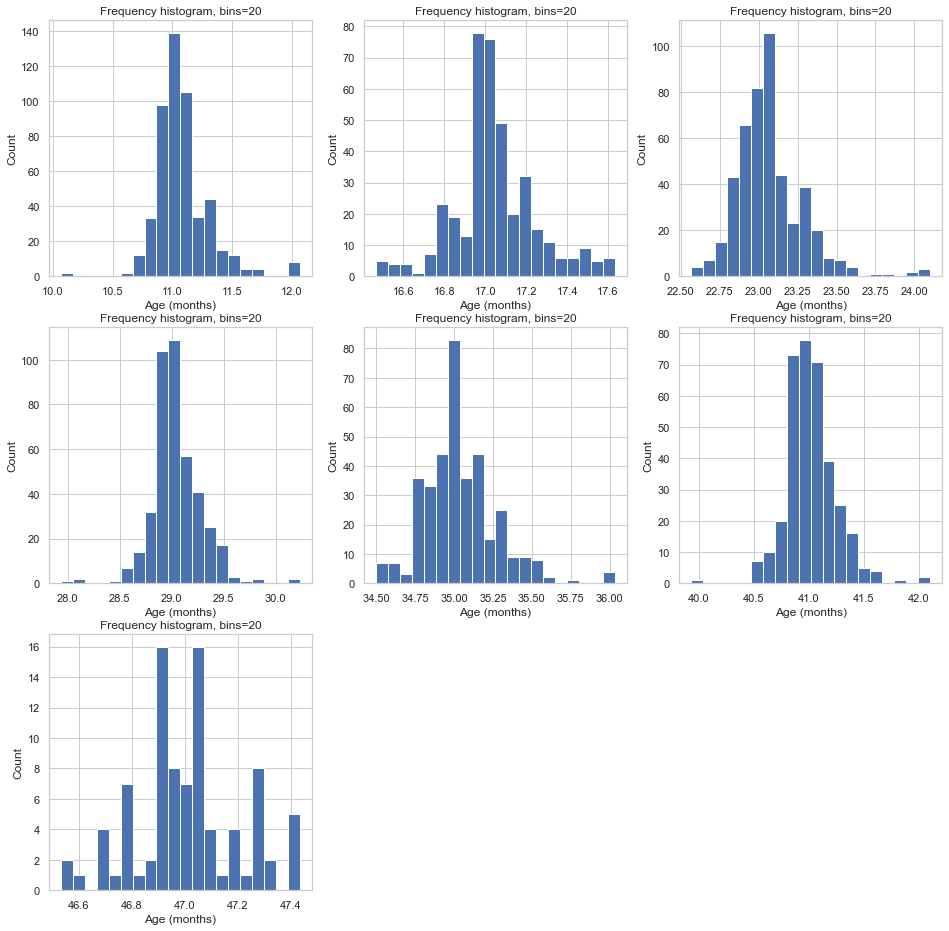

In [21]:
%matplotlib inline

bins = 20

fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:
        ax.hist(data[i]['age_months'], bins=bins)
        ax.set_xlabel('Age (months)')
        ax.set_ylabel('Count')
        ax.set_title(f'Frequency histogram, bins={bins}')

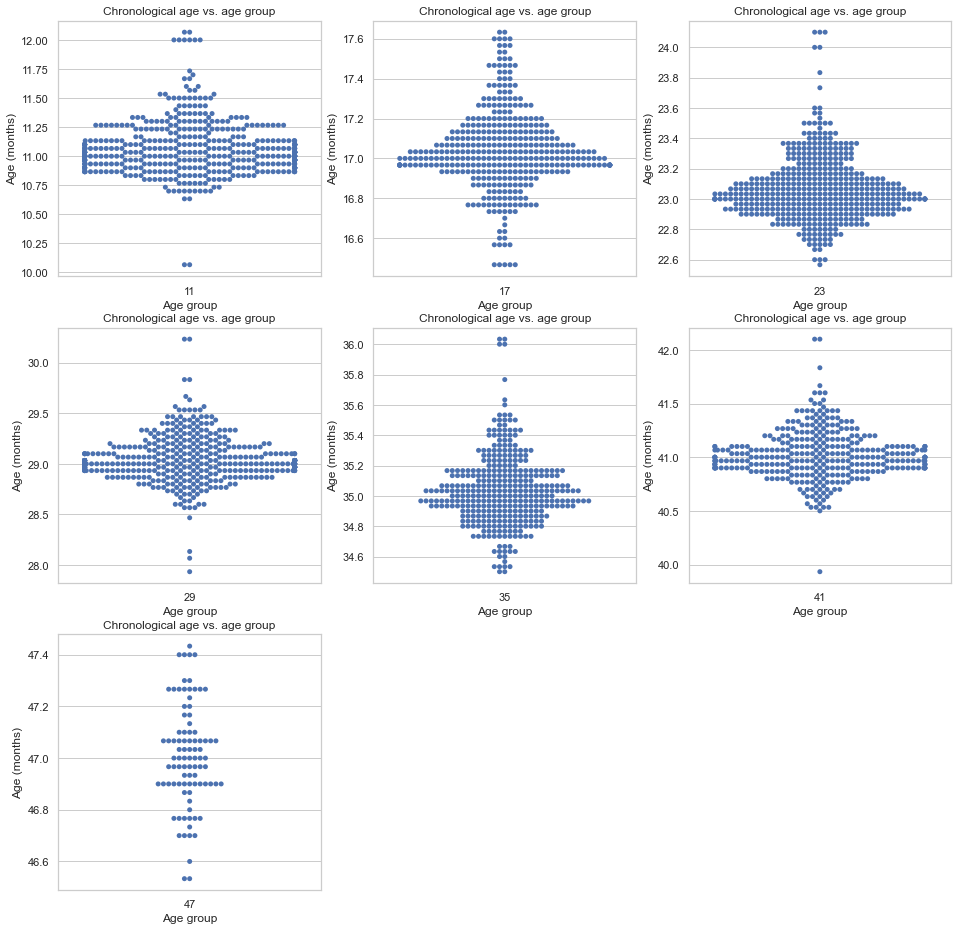

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:
        sns.swarmplot(ax=ax, x="age_group", y="age_months", data=data[i])
        ax.set_xlabel('Age group')
        ax.set_ylabel('Age (months)')
        ax.set_title('Chronological age vs. age group')

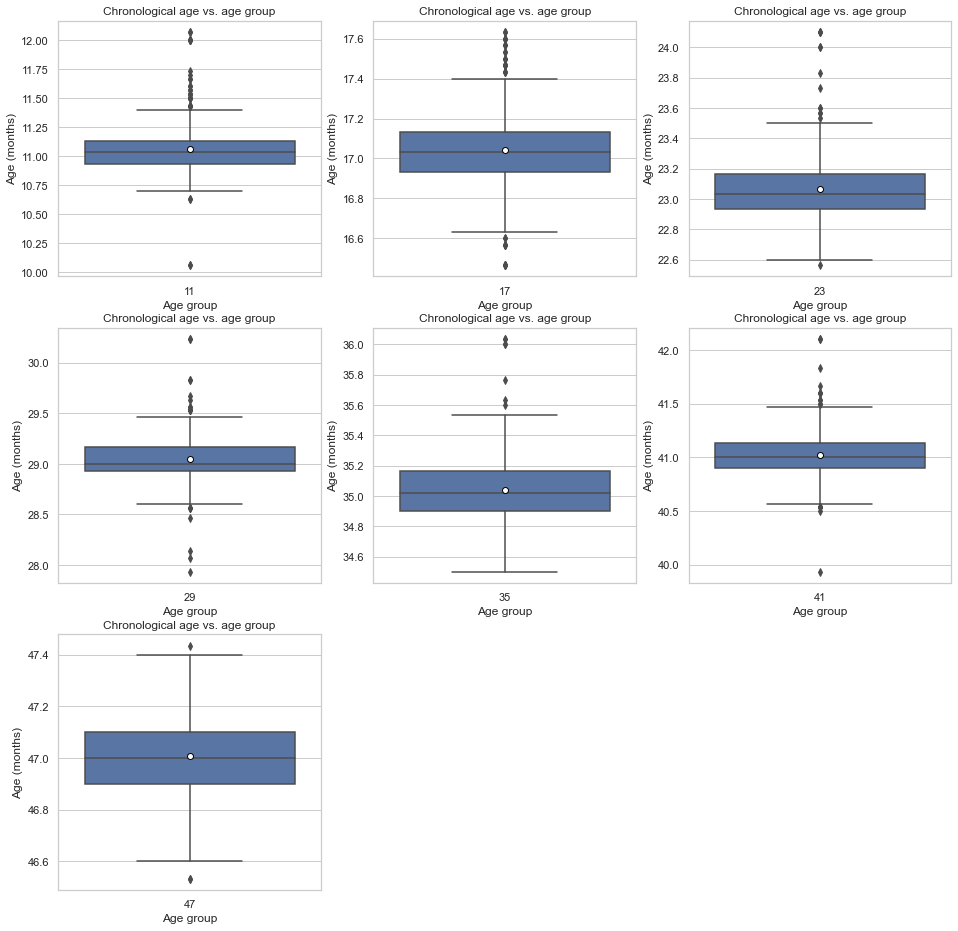

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:    
        sns.boxplot(ax=ax, x="age_group", y="age_months", data=data[i], showmeans=True, 
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                           "markersize":"6"})
        ax.set_xlabel('Age group')
        ax.set_ylabel('Age (months)')
        ax.set_title('Chronological age vs. age group')

## Check files with no label 

In [24]:
merged_df.loc[merged_df['age_days'].isnull()]

,code,age_days,age_months,age_years,age_group,cnt_path,cnt_file


### Fill in the missing age data based on the age group the subject is in

We know the age group (i.e. 11, 17, 23, .. months etc) of all the subjects, based on the folder the files are in and based on the file name. We have got the exact ages (in days) of most subjects seperately, which we have added to the DataFrame above. For some of the subjects, we don't have the exact age and therefore we set this equal to the age group.

In [25]:
merged_df['age_months'].fillna(merged_df['age_group'], inplace=True)
merged_df['age_days'].fillna(merged_df['age_group']*30, inplace=True)
merged_df['age_years'].fillna(merged_df['age_group']/12, inplace=True)

Below should now return an empty dataframe, because all empty fields have been filled

In [26]:
merged_df.loc[merged_df['age_days'].isnull()]

,code,age_days,age_months,age_years,age_group,cnt_path,cnt_file


In [27]:
merged_df

,code,age_days,age_months,age_years,age_group,cnt_path,cnt_file
0,1,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk
1,1,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\1_naki...,1_nakijken_mmn3-6
2,3,336,11.200000,0.933333,11,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp
3,5,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2
4,6,319,10.633333,0.886111,11,NaN,NaN
...,...,...,...,...,...,...,...
2597,731,1409,46.966667,3.913889,47,NaN,NaN
2598,732,1412,47.066667,3.922222,47,NaN,NaN
2599,733,1404,46.800000,3.900000,47,NaN,NaN
2600,734,1405,46.833333,3.902778,47,NaN,NaN


## Explore EEG data

### Import EEG data (from .cnt files)

In [28]:
#merged_df.loc[50]
merged_df['cnt_path'][50]

'C:/Projects/EEG_explorer/Data\\11mnd mmn\\103_11_mr_mmn2.cnt'

In [29]:
# Select a file
file = merged_df['cnt_path'][50] # just a random file number

# Import file 
data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True)

Reading 0 ... 739079  =      0.000 ...  1478.158 secs...


## What does the data look like?

In [30]:
print('Data type: {}\n\n{}\n'.format(type(data_raw), data_raw))

# Get the sample rate
print('Sample rate:', data_raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(data_raw.get_data().shape))

# The mne.info class can be used to learn more about the data.
print(data_raw.info)

Data type: <class 'mne.io.cnt.cnt.RawCNT'>

<RawCNT | 103_11_mr_mmn2.cnt, 64 x 739080 (1478.2 s), ~360.9 MB, data loaded>

Sample rate: 500.0 Hz
Size of the matrix: (64, 739080)

<Info | 8 non-empty values
 bads: []
 ch_names: O2, O1, OZ, PZ, P4, CP4, P8, C4, TP8, T8, P7, P3, CP3, CPZ, CZ, ...
 chs: 62 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>


### Show data as pandas dataframe (i.e. as a table).
The raw data itself is just an array dimensions are no. of channels and timepoint.

In [31]:
raw_df = data_raw.to_data_frame()
raw_df.head()

,time,O2,O1,OZ,PZ,P4,CP4,P8,C4,TP8,...,F2,F6,FC5,F1,AF4,AF8,F5,AF7,AF3,FPZ
0,0,4212.100233,-447.466426,-32.380952,246.503494,200.610559,31.010454,-5701.260986,-41.003460,-113.138360,...,-116.407601,-284.455962,-326.530621,141.913052,108.492203,-108.192469,-443.785444,-242.482515,-233.752715,-387.375689
1,2,4267.588564,-447.986132,-28.051948,246.328669,201.308334,32.404182,-5701.260986,-41.003460,-113.836745,...,-115.889466,-283.246981,-326.704308,142.086965,108.665513,-106.285230,-443.436556,-240.734263,-229.761391,-384.608719
2,4,4405.704380,-442.615842,-16.796537,252.272724,203.924994,38.675959,-5701.260986,-35.986159,-121.868172,...,-110.880830,-277.374787,-317.672610,148.173922,109.705374,-86.345913,-435.935466,-228.321676,-221.605209,-381.841750
3,6,4511.322357,-435.339965,-3.636364,258.566431,199.912783,44.599304,-5701.260986,-30.622837,-130.947176,...,-108.635580,-273.402421,-308.640912,152.869575,107.279031,-65.886439,-429.829927,-216.083914,-218.655100,-381.322943
4,8,4475.194440,-432.914673,5.021645,260.139857,187.003929,46.689897,-5701.260986,-28.719723,-132.343946,...,-113.644215,-275.647671,-307.946166,149.391314,100.866553,-61.031649,-431.399923,-213.286711,-225.770068,-385.473397


In [32]:
data_raw.info['bads']

[]

In [33]:
# Band-pass filter (between 1 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
data_raw.filter(1, 40, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)



<RawCNT | 103_11_mr_mmn2.cnt, 64 x 739080 (1478.2 s), ~360.9 MB, data loaded>

### Plot channels

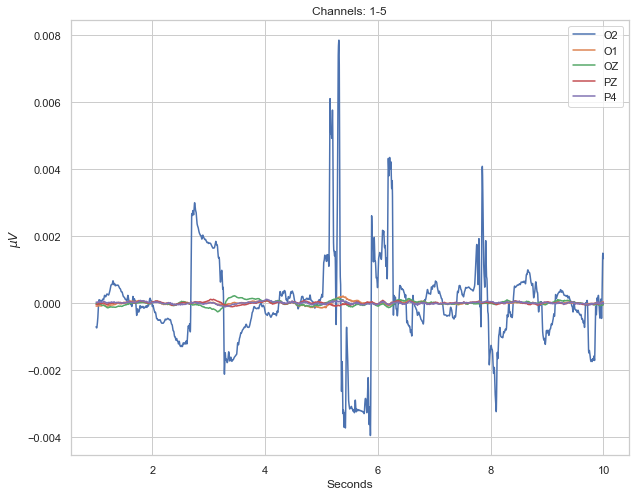

In [34]:
# Extract data from the first 5 channels, from 1 s to 10 s.
sfreq = data_raw.info['sfreq']
data, times = data_raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T)
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-5')
plt.legend(data_raw.ch_names[:5])

### mne plots
There are many nice plotting options included in mne. They are, however, not always interactive and fully functional in Jupyter notebooks... so better try them out from a python script.

In [ ]:
data_raw.plot(duration=10, block=True)

Using qt as 2D backend.
Opening raw-browser...


### Look at events 

In [ ]:
# get the events
events, event_id = mne.events_from_annotations(data_raw)
print(events[:10,:])
print(event_id)

In [ ]:
# Check which unique event indentifiers there are
unique_event_types = set(events[:,2])
print(unique_event_types)

### Search for most common event

In [ ]:
# tmin = -0.2
# tmax = 0.8

# baseline = (None, 0)  # means from the first instant to t = 0
# counts = pd.Series()

# for i, path in enumerate(merged_df['cnt_path']):    # enumerate is a for loop for indeces and content    
#     # Import file - not optimized code!
#     try:
#         raw = mne.io.read_raw_cnt(path, eog='auto', preload=True, verbose=False)
#     except: 
#         continue
    
#     # Load events
#     events_count, event_id_count = mne.events_from_annotations(raw, verbose=False)    
#     event_id_count = {y:x for x,y in event_id_count.items()}
    
#     temp_df = pd.DataFrame(events_count) 
#     temp_df[2].replace(event_id_count, inplace=True)
#     counts = counts.add(temp_df[2].value_counts(),fill_value=0)

# print(counts)

# # 0        3567.0
# # 1       13263.0
# # 10         18.0
# # 104         1.0
# # 11         12.0
# # 112         2.0
# # 12      44920.0
# # 127       304.0
# # 13     120790.0
# # 14       8649.0
# # 15       6600.0
# # 16         13.0
# # 17         13.0
# # 18         93.0
# # 19         75.0
# # 2      357282.0
# # 20         15.0
# # 201         2.0
# # 202         2.0
# # 203         2.0
# # 204         2.0
# # 205         2.0
# # 206         2.0
# # 208         2.0
# # 209         2.0
# # 21         10.0
# # 210         2.0
# # 211         2.0
# # 255         2.0
# # 26          1.0
# # 27          1.0
# # 3      878840.0
# # 31          1.0
# # 33        614.0
# # 35          1.0
# # 36          2.0
# # 4       72045.0
# # 40         12.0
# # 41          4.0
# # 45          1.0
# # 48         18.0
# # 49         10.0
# # 5       55476.0
# # 55      44602.0
# # 58          5.0
# # 6          12.0
# # 60          9.0
# # 65          5.0
# # 66      91848.0
# # 7          12.0
# # 72          4.0
# # 73          7.0
# # 77       8969.0
# # 8          13.0
# # 80         62.0
# # 81         31.0
# # 82          8.0
# # 88       6894.0
# # 9          12.0
# # 99      28749.0
# # dtype: float64

### Display signal around one type of event
Selects signal for specific event ID and plots time window from tmin to tmax.

In [ ]:
# event_id = [1, 2, 3, 4] # select events for the given event IDs
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

baseline = (None, 0)  # means from the first instant to t = 0
picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

print(picks)

In [ ]:
epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=baseline, preload=True, verbose=True)

print(epochs)

In [ ]:
# Export data in tabular structure as a pandas DataFrame.
epochs_df = epochs.to_data_frame()
epochs_df.head()

In [ ]:
print(epochs)

In [ ]:
evoked = epochs['5'].average()
evoked.plot()

In [ ]:
# Spatial plot:
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

### Plot topomaps for different time points

In [ ]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

### Test other event type

In [ ]:
evoked = epochs['4'].average()
evoked.plot()
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

In [ ]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

# Adding a montage to the data

Montages specify the exact electrode placement on the scalp of the subject. This contains coordinates relative to a point on the scalp. Often this data is included in the EEG data (.cnt file). Unfortunately for us, we don't have this information. The electrode placement information can be used to fix broken channels by using the channels surrounding this channel. Even though we don't have the exact locations, we do know the electrode placement system used: 10-20. We can use this to approximate the locations.

### When looking at the maps above, the electrode placement seems to be incorrect

In [ ]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
data_raw.plot_sensors(ch_type='eeg', axes=ax2d)
data_raw.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

In [ ]:
layout_from_raw = mne.channels.make_eeg_layout(data_raw.info)
layout_from_raw.plot()

### Unfortunately, we don't have the exact sensor locations. Therefore, we try to approximate them with a standard montage.

Standard montages come with the mne package. They're based on well known and often used electrode placement systems (10-20 in our case).

In [ ]:
print(data_raw.ch_names)

In [ ]:
len(data_raw.ch_names)

In [ ]:
montage = mne.channels.make_standard_montage('standard_1020')
montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]

In [ ]:
montage.plot(kind='topomap', show_names=True)

In [ ]:
data_raw_1020 = data_raw.copy().set_montage(montage)

### Now, after setting the 1020 montage, the maps look different

In [ ]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
data_raw_1020.plot_sensors(ch_type='eeg', axes=ax2d)
data_raw_1020.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

In [ ]:
layout_from_raw = mne.channels.make_eeg_layout(data_raw_1020.info)
layout_from_raw.plot()

## Custom cnt-file import function:

In [ ]:
# signal_collection = np.zeros((0,3,5))
# signal_collection

In [ ]:
def read_cnt_file(file,
                  label_group,
                  event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                  channel_set = "30",
                  tmin = -0.2,
                  tmax = 0.8,
                  lpass = 0.5, 
                  hpass = 40, 
                  threshold = 5, 
                  max_bad_fraction = 0.2,
                  max_bad_channels = 2):
    """ Function to read cnt file. Run bandpass filter. 
    Then detect and correct/remove bad channels and bad epochs.
    Store resulting epochs as arrays.
    
    Args:
    --------
    file: str
        Name of file to import.
    label_group: int
        Unique ID of specific group (must be >0).
    channel_set: str
        Select among pre-defined channel sets. Here: "30" or "62"
    """
    
    if channel_set == "30":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1']
    elif channel_set == "62":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'AFZ', 'PO3', 
                       'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 
                       'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 
                       'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']
    else:
        print("Predefined channel set given by 'channel_set' not known...")
        
    
    # Initialize array
    signal_collection = np.zeros((0,len(channel_set),501)) # prepare dimensions of slice, start with zero?
    label_collection = [] #np.zeros((0))
    channel_names_collection = []
    
    # Import file
    try:
        data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True, verbose=False)
    except ValueError:
        print("ValueError")
        print("Could not load file:", file)
        return None, None, None
    
    # Band-pass filter (between 0.5 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
    data_raw.filter(0.5, 40, fir_design='firwin')

    # Get events from annotations in the data
    events_from_annot, event_dict = mne.events_from_annotations(data_raw)
    
    # Set baseline:
    baseline = (None, 0)  # means from the first instant to t = 0

    # Select channels to exclude (if any)
    channels_exclude = [x for x in data_raw.ch_names if x not in channel_set]
    channels_exclude = [x for x in channels_exclude if x not in ['HEOG', 'VEOG']]
    
    for event_id in event_idx:
        if str(event_id) in event_dict:
            # Pick EEG channels
            picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                               #exclude=data_exclude)#'bads'])
                                   include=channel_set, exclude=channels_exclude)#'bads'])

            epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                baseline=baseline, preload=True, event_repeated='merge', verbose=False)

            # Detect potential bad channels and epochs
            bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs,
                                                                          event_id,
                                                                          threshold = threshold,
                                                                          max_bad_fraction = max_bad_fraction)

            # Interpolate bad channels
            # ------------------------------------------------------------------
            if len(bad_channels) > 0:
                if len(bad_channels) > max_bad_channels:
                    print(20*'--')
                    print("Found too many bad channels (" + str(len(bad_channels)) + ")")
                    return None, None, None
                else:
                    # MARK: Setting the montage is not verified yet (choice of standard montage)
                    montage = mne.channels.make_standard_montage('standard_1020')
                    montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]
                    data_raw.set_montage(montage)
                    
                    # TODO: Think about using all channels before removing (62 -> 30), to enable for better interpolation
                    
                    # Mark bad channels:
                    data_raw.info['bads'] = bad_channels
                    # Pick EEG channels:
                    picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       #exclude=data_exclude)#'bads'])
                                       include=channel_set, exclude=channels_exclude)#'bads'])
                    epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                        tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                        baseline=baseline, preload=True, verbose=False)
                    
                    # Interpolate bad channels using functionality of 'mne'
                    epochs.interpolate_bads()
                    

            # Get signals as array and add to total collection
            channel_names_collection.append(epochs.ch_names)
            signals_cleaned = epochs[str(event_id)].drop(bad_epochs).get_data()
            # print(signals_cleaned)
            signal_collection = np.concatenate((signal_collection, signals_cleaned), axis=0) # adds to signal collection
            label_collection += [event_id + label_group] * signals_cleaned.shape[0]

    return signal_collection, label_collection, channel_names_collection

In [ ]:
#signal_collection -> signal_collect

In [ ]:
signal_collect, label_collect, channel_names_collection = read_cnt_file(merged_df['cnt_path'][20], 
                                                                        merged_df['age_months'][0],
                                                                        event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                                        channel_set = "30",
                                                                        tmin = -0.2,
                                                                        tmax = 0.8,
                                                                        lpass = 0.5, 
                                                                        hpass = 40, 
                                                                        threshold = 5, 
                                                                        max_bad_fraction = 0.2,
                                                                        max_bad_channels = 2)

In [ ]:
signal_collect.shape

In [ ]:
len(label_collect)

In [ ]:
# needs investigation
signal_collect.shape, 

In [ ]:
len(label_collect)

In [ ]:
# # needs investigation- not defined anywhere
# metadata_collection[:10]

# Feature extraction and save processed data

## Determine how to store the processed data

Below we're determining what the best method is to extract and save the features. At the end, we combine all the parts.

In [ ]:
for i, file in merged_df.iterrows():
    
    # Import data and labels
    signal_collect, label_collect, ch_names = read_cnt_file(file['cnt_path'],
                                                            file['age_months'],
                                                            event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)    
        
    # Save data and labels
    # ---------------------------------------------------------
    if signal_collect is None:
        continue
        
    local_processed_data = 'C:/Projects/EEG_explorer/Data/data_processed_ML'

    # Firstly, save the metadata which will be the same for all files derived from this .cnt file
    filename_metadata = os.path.join(local_processed_data, "processed_data_" + file['cnt_file'] + ".csv")
    # create a pandas dataframe out of file, invert rows and columns and outputs a csv at filename_metadata
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)        
    
    # Save all the epochs to separate files
    filename_signal = os.path.join(local_processed_data, "processed_data_" + file['cnt_file'] + ".npy")
    np.save(filename_signal, signal_collect) # save signal collect into .npy file with name on line above
    
    break # MARK: Remove this!

## Extract features that can be used for machine learning models

In [ ]:
from mne_features.feature_extraction import extract_features

### Extract features from the raw data to reduce dimensionality

In [ ]:
# User defined functions

def compute_rms(data):
    """Root-mean squared value of the data (per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: *rms*
    """
    return np.sqrt(np.mean(np.power(data, 2), axis=-1))

In [ ]:
#import mne_features
# Select features from the raw data for machine learning
selected_features = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'std', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq', 'ptp_amp'}

X_new = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)
# pro
#mne_features.feature_extraction.extract_features(X, sfreq, selected_funcs, funcs_params=None, n_jobs=1, ch_names=None, return_as_df=Fa

In [ ]:
X_new

The raw data had a shape of (1917, 30, 501) - the extracted features data is almost 30 times smaller (before feature selection):

In [ ]:
X_new.shape

### Search for highly correlated features and remove one of them

Some features are often highly correlated and therefore don't add a lot of additional information to the model. To further reduce dimensionality, one of the two highly correlated features can be removed.

In [ ]:
X_new_1 = X_new.iloc[:, X_new.columns.get_level_values(1)=='1']

In [ ]:
# Select only the first channel for all features

X_new_1

In [ ]:
#correlation = X_new_1.corr()
correlation = X_new.corr()

In [ ]:
sns.heatmap(correlation)

In [ ]:
correlation

In [ ]:
correlation.ge(0.9)

"""
Highly correlated (>0.90), channel 0:
- std & rms (0.926)
- std & ptp_amp (0.9688)
- std & variance (0.952)
- ptp_amp & variance (0.900)

Highly correlated (>0.90), channel 1:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance

Highly correlated (>0.90), channel 2:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance

Highly correlated (>0.90), channel 3:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 3:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 4:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 5:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance
"""

After inspecting a few channels and the correlation between the features, the features 'std' and 'ptp_amp' can be removed, because they have a high correlation with eachother, 'rms' and 'variance'. Removing these two features will reduce the dimensionality.

### Feature extraction after selection

In [ ]:
# Removed features: std, ptp_amp
selected_features_selection = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq'}

X_new_selection = extract_features(signal_collect, 500.0, selected_features_selection, return_as_df=1)

In [ ]:
X_new_selection

In [ ]:
X_new_selection.columns

The different channels aren't identifiable by the current naming method. Map the numbers to the actual channel name and flatten the MultiIndex column dataframe.

In [ ]:
channel_names_collection[0]

In [ ]:
# Update the column names

import re

def flatten_multiindex(multiindex):
    cols = []

    for category, subcategory in multiindex:
        # energy_freq_bands features
        if '_' in subcategory:
            prefix, suffix = subcategory.split('_')
        else:
            prefix, suffix = subcategory, None
        start, end = re.search(r'\d+', prefix).span()
        chindex = int(prefix[start:end])
        channel = channel_names_collection[0][chindex]
        colname = '_'.join(c for c in (category, suffix, channel) if c)
        cols.append(colname)
    return cols

In [ ]:
X_new_selection.columns = flatten_multiindex(X_new_selection.columns)

In [ ]:
X_new_selection.columns

# Putting the feature extraction, selection and saving steps together

Steps:

1. Check if files don't already exist
2. Load EEG data
3. Extract features
4. Save metadata, save features dataframe

In [ ]:
# TODO: Check the band ranges used
selected_features = {
    'mean',
    ('root_mean_squared', compute_rms),
    'hjorth_mobility',
    'hjorth_complexity',
    'variance',
    'kurtosis',
    'skewness',
    'app_entropy',
    'zero_crossings',
    'energy_freq_bands',
    'spect_edge_freq',
}

for i, file in merged_df.iterrows():
    print(f"Checking out file: {file['cnt_file']}")
        
    filename_extracted_features = os.path.join(local_processed_data, f"extracted_features_{file['cnt_file']}.h5")
    filename_metadata = os.path.join(local_processed_data, f"processed_data_{file['cnt_file']}.csv")
    
    # Step 1: Check if file don't already exist, else skip
    if os.path.exists(filename_extracted_features) and os.path.exists(filename_metadata):
        print(f"Skipping because {filename_extracted_features} and {filename_metadata} already exist.")
        continue

    # Step 2: Import data and labels 
    signal_collect, label_collect, ch_names = read_cnt_file(
        file['cnt_path'],
        file['age_months'],
        event_idx=[2, 3, 4, 5, 12, 13, 14, 15],
        channel_set="30",
        tmin=-0.2,
        tmax=0.8,
        lpass=0.5,
        hpass=40,
        threshold=5,
        max_bad_fraction=0.2,
        max_bad_channels=2,
    )    
    
    if signal_collect is None:
        continue
    
    # Step 3: Extract the features from the raw data
    try:
        extracted_features = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)

    except:
        print(f"Skipping because {file['cnt_file']} causes error when extracting features.")
        continue
    
    # Change the DataFrame from hierarchical column structure ('mean' -> ch1, ch2, ch3) 
    # to flat column structure ('mean-ch1', 'mean-ch2', etc..)

    extracted_features.columns = flatten_multiindex(extracted_features.columns)
    
    # Step 4: Save metadata (same for all files derived from this .cnt file), save the extracted features
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)     
    extracted_features.to_hdf(filename_extracted_features, key='df', mode='w')
    # TODO: 1. Try saving 2. Retry after n seconds if fails 3. If fails m times, continue
    
        


In [ ]:
# extracted_features

In [ ]:
# extracted_features.columns

In [ ]:
# col_names = []

# for i, j in extracted_features.columns:
#     col_names.append(f'{i}_{j}')
# col_names
        

In [ ]:
# extracted_feat

In [ ]:
extracted_features

In [ ]:
    # Change the DataFrame from hierarchical column structure ('mean' -> ch1, ch2, ch3) 
    # to flat column structure ('mean-ch1', 'mean-ch2', etc..)
#     col_names = []

#     for i, j in extracted_features.columns:
#         try:
#             col_names.append(f'{i}_{channel_names_collection[0][int(j)]}')
#         except ValueError:
#             # energy_freq_bands feature has different naming
#             str_parts = j.split('_')        
#             ch_num = re.findall("\d+", str_parts[0])[0]
#             col_names.append(f'{i}_{str_parts[1]}_{channel_names_collection[0][int(ch_num)]}')
        
# extracted_features.columns = col_names
    
#     # Step 4: Save metadata (same for all files derived from this .cnt file), save the extracted features
# pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)     
# extracted_features.to_hdf(filename_extracted_features, key='df', mode='w')
#     # TODO: 1. Try saving 2. Retry after n seconds if fails 3. If fails m times, continue

In [ ]:
extracted_features

### Sanity check: test loading the saved file from disk

In [ ]:
# df_load = pd.read_hdf(os.path.join(PATH_DATA_PROCESSED_ML,"extracted_features_009_11_jc_mmn36_wk_mmn25_wk.h5"))
# needs to check a particular file it worked for

df_load = pd.read_hdf(os.path.join(PATH_DATA_PROCESSED_ML,"extracted_features_005_11_jc_mmn2.h5"))

In [ ]:
df_load